In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [9]:
"""try:
    import ipyparallel
except:
    import sys
    !conda install --yes --prefix {sys.prefix} ipyparallel
"""
try:
    from ema_workbench import Model, RealParameter, ScalarOutcome, perform_experiments, TimeSeriesOutcome
except:
    import sys
    !pip install --prefix {sys.prefix} ema_workbench
    from ema_workbench import Model, RealParameter, ScalarOutcome, perform_experiments, TimeSeriesOutcome
    
from ema_workbench import MultiprocessingEvaluator
from ema_workbench.analysis.plotting import lines, envelopes, kde_over_time
from ema_workbench.analysis.plotting import Density
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.special import binom
import time
import cloudpickle
from pathlib import Path
import datetime

In [10]:
# this is not used
_ = """def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

@static_vars(time_r0=0,crossed_r0=False,time_d14=0,crossed_d14=False)
def lockdown_state(time=0.,r0=10.,d14=1.):
    if not lockdown_state.crossed_r0 and r0 <=1.:
        lockdown_state.crossed_r0 = True
        lockdown_state.time_r0 = time
    elif r0 > 1.:
        lockdown_state.crossed_r0 = False
        lockdown_state.time_r0 = 0
    if not lockdown_state.crossed_d14 and d14 > 40.:
        lockdown_state.crossed_d14 = True
        lockdown_state.time_d14 = time
    elif d14 < 40.:
        lockdown_state.crossed_d14 = False
        lockdown_state.time_d14 = 0
    
    dt_r0 = time-lockdown_state.time_r0
    dt_d14 = time-lockdown_state.time_d14
    if lockdown_state.crossed_r0:
        if not lockdown_state.crossed_d14:
            lockdown = 60.
        else:
            lockdown = 50.
    else:
        lockdown = 80.
        
    return ({"lockdown":lockdown})"""

# The Model

There is two classes, World, and Country. Each country has a days_to_travel attribute, and, when called, will indicate if it is open for travel, or locked down for travel:

`Country.can_travel(125) :== is this country open on day 125`

The simulation is set up such that,
* for each country
* define a low/high band of when it may open up for travel
* for each simulation iteration
* pick a random number inside that band
* perform this, at each iteration step, where all countries have a set time_to_travel, a loop from 0 to max_time and compute the portion of travel that is possible
* each country contributes evenly to travel recovery

In [11]:
class Country():
    def __init__(self,days_to_allow_travel=np.random.randint(50,200),name=""):
        self.time = 0
        self.days_to_allow_travel = days_to_allow_travel
        # generate random country names unless specified
        if name == "":
            n = ""
            for i in range(3):
                n += chr(np.random.randint(ord("A"),ord("Z")))
            self.name = n
        else:
            self.name = name
        
    def can_travel(self,time,dtat=-1):
        if dtat < 0: # this should not happen ever
            if time >= self.days_to_allow_travel:
                retval = 1
            else:
                retval = 0
        else:
            if time >= dtat:
                retval = 1
            else:
                retval = 0
        return {"can_travel":retval}
        

class World():
    def __init__(self,max_time,**kwargs):
        """
        max_time is the actual simulation time
        dtat_n days_to_allow_travel for country n is a starting point but gets overwritten during the simulation
        name_n is generated as a fake three letter country code (not used)
        """
        self.countries = [] # these are actual objects of class  Country
        self.dtat = {}
        self.names = {}
        # kwargs will be dtat_0=79, dtat_1=121 etc etc
        for k,v in kwargs.items():
            if k[:5] == "dtat_":
                # initialisation. Note dtat will be overwritten during the simulation
                self.countries.append(Country(days_to_allow_travel=v))
            elif k[:5] == "name_":
                self.names[int(k.split("_")[1])] = v
        # each country's contribution to travel
        # to be replaced with an actual volume (IN<->US, DE<->UK)
        self.travel_volume_portion = 1/binom(len(self.countries)-1,2) 
        # simulation time
        self.max_time = max_time
        return
    
    def decode_params(self,**kwargs):
        # overwrite days_allow_to_travel by number generated for the simulation run
        for k,v in kwargs.items():
            if k[:5] == "dtat_":
                self.countries[int(k.split("_")[1])].days_to_allow_travel = v
    
    def travel_volume(self,**kwargs):
        # here is where we overwrite the days_allowed_to_travel
        self.decode_params(**kwargs)
        volumes = []
        # for a time series simulation, each object needs to perform its own time loop
        # the workbench does not loop through time as it has no concept of time steps
        for time in range(self.max_time):
            volume = 0
            for i in range(len(self.countries)):
                for j in range(i+1,len(self.countries)):
                    # if both countries allow travel (this is not specific for this simple model,
                    # just "travel as such")
                    retval_1 = self.countries[i].can_travel(time)
                    retval_2 = self.countries[j].can_travel(time)
                    if  retval_1["can_travel"] > 0 and retval_2["can_travel"] > 0:
                        volume += self.travel_volume_portion
            volumes.append(volume)
        # volumes is now a time series
        return {"volumes":volumes}

Set up the parameters and initialise everything. Gimmick: `**kwargs` is actually a dict, so it is set up as a dict `{"dtat_0":132,"dtat_1":92,...,"dtat_234":71}`

In [12]:
COUNTRIES = []
kwargs = {}
alldata = []

max_time = 350

for i in range(235):
    # set up a list of dummy parameter names dtat_0, dtat_1, ... dtat_234
    parameter = "dtat_{}".format(i)
    # define a band inside which the simulation should modulate the parameters
    # each country gets a low and high number of days to travel, and the workbench is meant
    # pick a random number low <= dtdt_fir_this_run <= high
    low = np.random.randint(50,250)
    high = 0
    # ensure high > low
    while high <= low:
        high = np.random.randint(100,max_time)
    COUNTRIES.append(RealParameter(parameter,low,high))
    # as kwargs is actually a dict, create it as a dict
    kwargs[parameter] = low
    alldata.append({"low":low,"high":high})

world = World(max_time,**kwargs)
model = Model('travel',function=world.travel_volume)

In [13]:
COUNTRIES[:5]

[RealParameter('dtat_0', 96, 346),
 RealParameter('dtat_1', 95, 178),
 RealParameter('dtat_2', 214, 321),
 RealParameter('dtat_3', 109, 150),
 RealParameter('dtat_4', 174, 239)]

# The Simulation

* Set up as a TimeSeries (as opposed to y)
* perform 100 runs, i.e. 100 different Worlds

In [14]:
START = time.time()
model.uncertainties = COUNTRIES
model.outcomes = [TimeSeriesOutcome('volumes',expected_range=(0.,1.))]

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=100)
    
print("Took {} seconds".format(time.time()-START))

Took 1163.6511704921722 seconds


1163 seconds on a single core cloud vCPU

238 seconds on a Xeon E3-1260L v5 @2.9 GHz

53 seconds on a AMD Ryzen 9 3950X 16x 3.50GHz

In [20]:
Path("/project_data/data_asset/mercury/ws3/ema_trials").mkdir(parents=True, exist_ok=True)

timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

with open("/project_data/data_asset/mercury/ws3/ema_trials/results.{}.pckld".format(timestamp),"w+b") as outfile:
    outfile.write(cloudpickle.dumps(results))

with open("/project_data/data_asset/mercury/ws3/ema_trials/world.{}.pckld".format(timestamp),"w+b") as outfile:
    outfile.write(cloudpickle.dumps(world))
    
with open("/project_data/data_asset/mercury/ws3/ema_trials/model.{}.pckld".format(timestamp),"w+b") as outfile:
    outfile.write(cloudpickle.dumps(model))

# Results

From here on, its just plotting things

In [21]:
alldata = []
for c in world.countries:
    alldata.append(c.days_to_allow_travel)
ddf = pd.DataFrame(alldata).rename(columns={0:"days_to_allow_travel"})

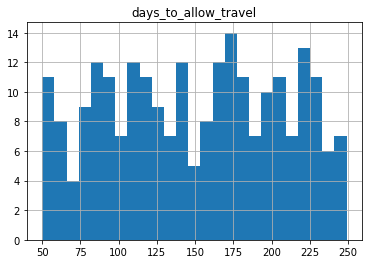

In [22]:
_ = ddf.hist(bins=25)

In [23]:
ddf

,days_to_allow_travel
0,96
1,95
2,214
3,109
4,174
5,235
6,85
7,246
8,165
9,128


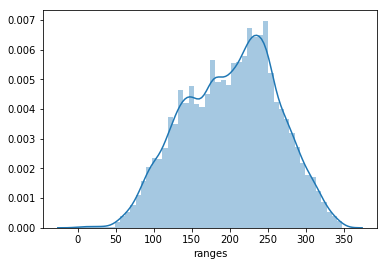

In [31]:
ddf = results[0].unstack().reset_index().rename(columns={0:"ranges"})
del ddf["level_0"]
del ddf["level_1"]
ddf = ddf.drop(ddf[ddf.ranges == "travel"].index)
ddf = ddf.drop(ddf[ddf.ranges == "None"].index)
ddf = ddf.drop(ddf[ddf.ranges > max_time].index)
_ = sns.distplot(ddf.ranges.apply(pd.to_numeric)) # had to convert to numeric https://stackoverflow.com/questions/7757386/valueerrorcolor-kwarg-must-have-one-color-per-dataset

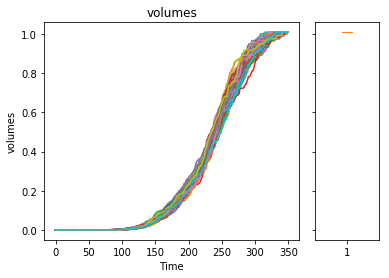

In [25]:
figure = lines(results[0],results[1],density=Density.BOXPLOT)
plt.show()

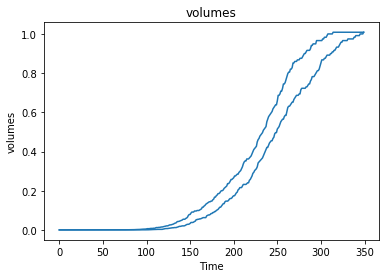

In [26]:
figure = envelopes(results[0],results[1])
plt.show()

singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix
singular matrix


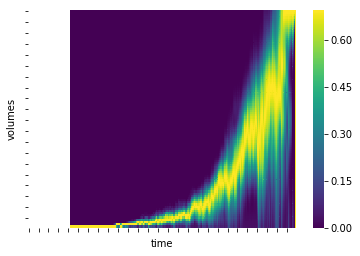

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    figure = kde_over_time(results[0],results[1])
    plt.show()

In [28]:
df = pd.DataFrame(results[1]["volumes"])

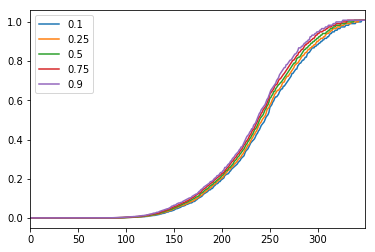

In [29]:
df.quantile([0.1,0.25,0.5,0.75,0.9]).transpose().plot()

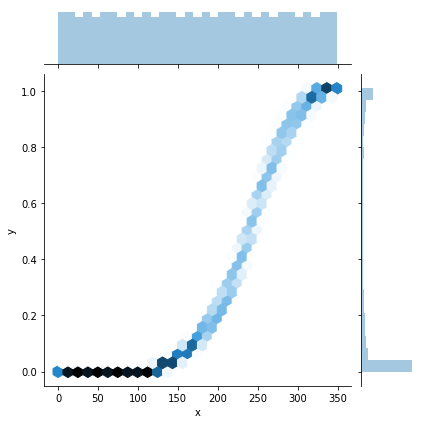

In [30]:
ddf = pd.DataFrame(df.unstack().droplevel(1)).rename(columns={0:"y"})
ddf["x"] = ddf.index.astype(float)

sns.jointplot(x="x",y="y",data=ddf,kind="hex")